# Treatments and timepoints

$$
y = \mu + \beta_1 \text{timepoint} + \beta_2 \text{treatment} + e
$$


## Read the data

Data from [The effects of lateral line ablation and regeneration in schooling giant danios](https://journals.biologists.com/jeb/article/221/8/jeb175166/300/The-effects-of-lateral-line-ablation-and)

(data repo [here](https://zenodo.org/record/4999506))

It's data on fish (*Devario aequipinnatus*) lateral line system, with the effect of chemical treatments (gentamycin or no treatment -- sham) at different timepoints.

In [38]:
import numpy as np ## arrays
import pandas as pd ## dataframes
import seaborn as sns ## plots
import statsmodels.api as sm ## statistical models
import matplotlib.pyplot as plt ## plots


In [6]:
## tab-separated text data
url= "https://zenodo.org/records/4999506/files/JEXBIO-2017-175166-Processed-Data-Master.txt"
danios = pd.read_csv(url, sep = "\t")

Dataset on *giant danios*: how the lateral line system responds to chemical treatments.

![giant danio](https://drive.google.com/uc?export=view&id=1kBpKQEg5Q6edFaSUsUCKZTi-XKA6Gva0)

In [12]:
danios

,Treatment,Week,NND,Time in School,Bearing,Elevation,Speed
0,Gentamycin,-1,0.574160,95,102.7958,-9.7755,2.561073
1,Gentamycin,-1,0.501053,92,53.7079,-4.2043,2.847107
2,Gentamycin,-1,0.061653,100,33.6143,61.8978,0.328393
3,Gentamycin,-1,0.141147,100,24.4592,-52.8579,0.222897
4,Gentamycin,-1,0.164253,100,81.6601,-74.0120,0.270351
...,...,...,...,...,...,...,...
291,Sham,8,0.786177,100,13.9269,-28.9844,3.234962
292,Sham,8,0.743846,100,26.6664,-30.1945,3.801309
293,Sham,8,0.110446,100,63.1979,-29.1439,3.731172
294,Sham,8,1.042831,92,137.1869,-6.5310,2.588874


In [11]:
## converting Week (timepoint) to string
danios['Week'] = danios['Week'].astype(str)

The target variables can be:

1.  nearest neighbor distance or NND (unit: body length),
2.  time in school (percentage),
3.  angular bearing (unit: degrees),
4.  angular elevation (unit: degrees),
5.  speed (body length per second).

Explanatory variables include:

-   `Treatment`: gentamycin / sham (control)
-   `Week`: time point in subsequent weeks (from week -1 to week 8)

## EDA

In [13]:
danios.describe()

,NND,Time in School,Bearing,Elevation,Speed
count,296.000000,296.000000,296.000000,296.000000,296.000000
mean,0.711611,87.182432,83.680545,0.134289,2.781253
std,0.700909,23.706979,51.249010,29.856673,3.251071
min,0.012489,0.000000,0.141300,-74.012000,0.053134
25%,0.305169,86.500000,40.259475,-17.618050,1.363638
50%,0.600457,100.000000,75.605800,0.198200,2.329494
75%,0.877326,100.000000,128.708400,18.712600,3.310707
max,7.108300,100.000000,179.500100,83.983600,44.170993


In [14]:
danios['Treatment'].value_counts()

,count
Treatment,
Sham,150
Gentamycin,146


In [15]:
danios['Week'].value_counts()

,count
Week,
8,58
0,51
4,51
2,50
1,45
-1,41


In [17]:
freq_table = pd.crosstab(danios['Treatment'], danios['Week'])
freq_table

Week,-1,0,1,2,4,8
Treatment,,,,,,
Gentamycin,16,26,20,25,26,33
Sham,25,25,25,25,25,25


In [27]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [25]:
# Assuming 'danios' is your DataFrame
mD = pd.melt(danios, id_vars=["Treatment", "Week"], var_name="target", value_name="value")
mD["Week"] = pd.Categorical(mD["Week"])

# Group and calculate mean
df_mean = mD.groupby(["Week", "Treatment", "target"], as_index=False).agg(avg=("value", "mean"))
df_mean.head()

<ipython-input-25-01488b4f91ee>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = mD.groupby(["Week", "Treatment", "target"], as_index=False).agg(avg=("value", "mean"))


,Week,Treatment,target,avg
0,-1,Gentamycin,Bearing,59.599481
1,-1,Gentamycin,Elevation,-10.120806
2,-1,Gentamycin,NND,0.174565
3,-1,Gentamycin,Speed,0.749538
4,-1,Gentamycin,Time in School,99.187500


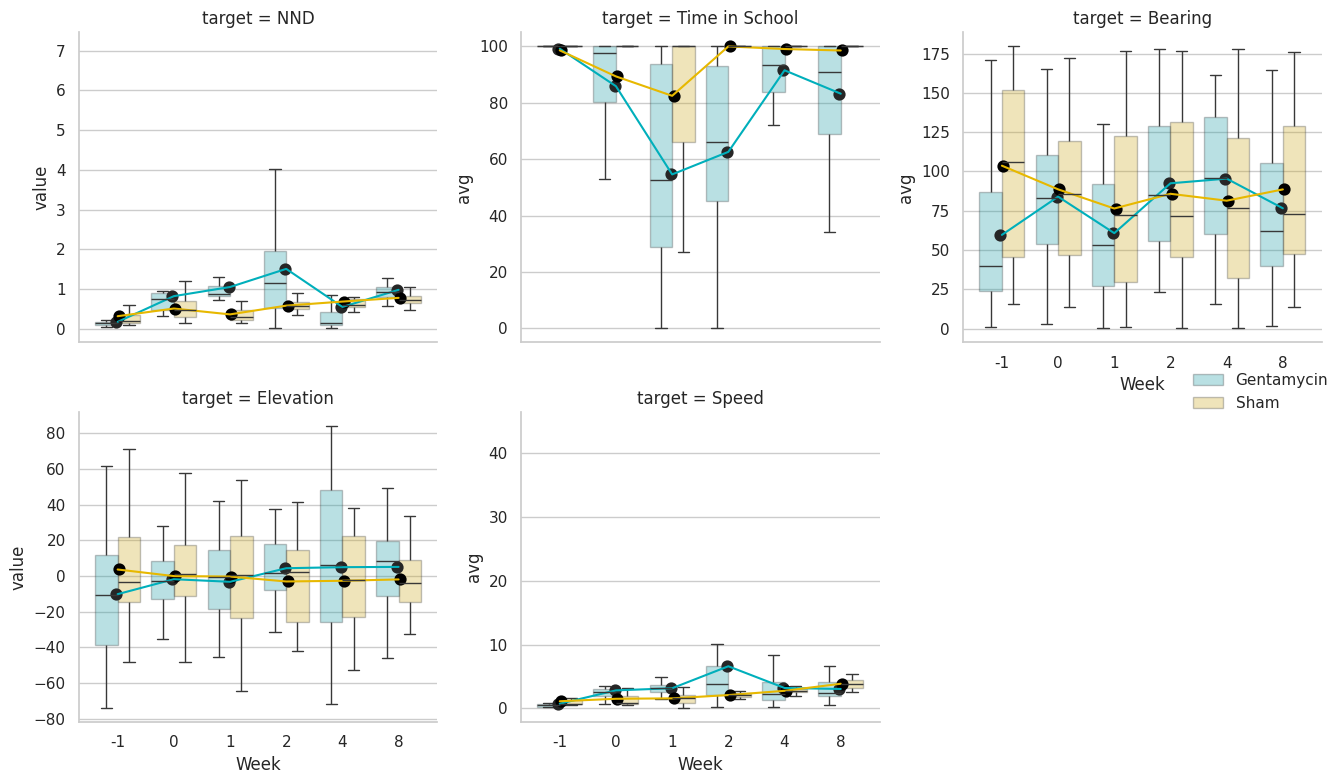

In [28]:
# Set plot style and color palette
palette = ["#00AFBB", "#E7B800", "#FC4E07"]
sns.set(style="whitegrid")

# Create a FacetGrid for each 'target'
g = sns.FacetGrid(mD, col="target", col_wrap=3, sharey=False, height=4, palette=palette)

# Boxplot
g.map_dataframe(sns.boxplot, x="Week", y="value", hue="Treatment", palette=palette, fliersize=0, boxprops=dict(alpha=0.3))

# Overlay points and lines for the mean
for ax, target in zip(g.axes.flat, mD["target"].unique()):
    subset = df_mean[df_mean["target"] == target]
    sns.pointplot(data=subset, x="Week", y="avg", hue="Treatment", ax=ax,
                  color="black", markers="o", linestyles="", dodge=True, legend=False)
    sns.lineplot(data=subset, x="Week", y="avg", hue="Treatment", ax=ax,
                 linewidth=1.5, palette=palette, legend=False)

# Adjust legend and layout
g.add_legend()
plt.tight_layout()
plt.show()

From reading the article, we expect the treatment to have an effect a little time after the application of gentamycin (vs control/sham) and then to see restoration when the cells of the lateral line system are regenerated.

------------------------------------------------------------------------

**Q: which target variables better show this expected pattern?**

------------------------------------------------------------------------

### Pick target variable

We select `Time in School` (based on the EDA above).

In [29]:
dd = danios.groupby(["Week", "Treatment"], as_index=False).agg(
    avg=("Time in School", "mean"),
    std=("Time in School", "std")
)

In [30]:
# Step 1: Pivot to wide format, calculate absolute difference, and drop columns
temp = dd.pivot(index="Week", columns="Treatment", values="avg").reset_index()
temp["diff"] = (temp["Gentamycin"] - temp["Sham"]).abs()
temp = temp[["Week", "diff"]]  # Keep only Week and diff

# Step 2: Merge back with original dd
dd = dd.merge(temp, on="Week", how="inner")

In [31]:
dd

,Week,Treatment,avg,std,diff
0,-1,Gentamycin,99.187500,2.286737,0.587500
1,-1,Sham,98.600000,7.000000,0.587500
2,0,Gentamycin,85.884615,21.274072,3.475385
3,0,Sham,89.360000,24.241631,3.475385
4,1,Gentamycin,54.600000,35.553370,27.880000
5,1,Sham,82.480000,28.622718,27.880000
6,2,Gentamycin,62.600000,33.154939,37.400000
7,2,Sham,100.000000,0.000000,37.400000
8,4,Gentamycin,91.538462,9.170521,7.541538
9,4,Sham,99.080000,3.213513,7.541538


In [33]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]


dd.style.apply(highlight_greaterthan, threshold=20.0, column=['diff'], axis=1)

,Week,Treatment,avg,std,diff
0,-1,Gentamycin,99.187500,2.286737,0.587500
1,-1,Sham,98.600000,7.000000,0.587500
2,0,Gentamycin,85.884615,21.274072,3.475385
3,0,Sham,89.360000,24.241631,3.475385
4,1,Gentamycin,54.600000,35.553370,27.880000
5,1,Sham,82.480000,28.622718,27.880000
6,2,Gentamycin,62.600000,33.154939,37.400000
7,2,Sham,100.000000,0.000000,37.400000
8,4,Gentamycin,91.538462,9.170521,7.541538
9,4,Sham,99.080000,3.213513,7.541538


## Models of analysis

1.  treatment within timepoint
2.  treatment + timepoint
3.  treatment + timepoint + (treatment x timepoint)

### Within timepoint

This is the simplest approach: we split the data by timepoint and make a comparison between treatments.

Now we get a much simpler dataset, with `Gentamycin`-treated and control fish records from week 2 only.

In [36]:
school_time = mD.loc[(mD['target'] == "Time in School")] ## !! REMEMBER THAT WE CHOSE ONE TARGET VARIABLE, Time in School !!
temp = school_time.loc[(school_time['Week'] == '2')]
temp

,Treatment,Week,target,value
358,Gentamycin,2,Time in School,70.0
359,Gentamycin,2,Time in School,100.0
360,Gentamycin,2,Time in School,17.0
361,Gentamycin,2,Time in School,90.0
362,Gentamycin,2,Time in School,74.0
363,Gentamycin,2,Time in School,72.0
364,Gentamycin,2,Time in School,45.0
365,Gentamycin,2,Time in School,36.0
366,Gentamycin,2,Time in School,100.0
367,Gentamycin,2,Time in School,51.0


Likewise, we can apply a very simple model:

$$
\text{Time in School} = \mu + \beta \cdot \text{Treatment} + e
$$

In [39]:
# Define the independent variables and add a constant for the intercept
X = temp[['Treatment']]
X = sm.add_constant(X)  # Adds the intercept term

# Define the dependent variable
y = temp['value']

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).